In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

## 1. Data generation

Create a function for generating the data. Both the input u (noisy stimulus) and the target output y (identity of the stimulus) are one-dimensional. The input $u(t) \in \mathbb{R}^1$  is defined by:

$
u(t) = 
\begin{cases}
\bar{u} + \xi(t), & \text{if } 5 \le t \le 45 \\
\xi(t), & \text{otherwise}
\end{cases}
$ 

$\bar{u}$ is the stimulus strength, drawn uniformly from $\pm \frac{3.2}{100} ({1, 2, 4, 8, 16})$, and $\xi$ is background noise, drawn from a normal distribution with mean 0 and standard-deviation 0.03.

The stimulus strength is re-sampled for each trial, the noise is re-sampled for each time-step. The target y is defined as the sign of $\bar{u}$. Write your function such that it can generate multiple trials at the same time, this will be useful for training our network using stochastic gradient descent. Plot the data for several trials to make sure the labels match the inputs, and the noise levels are reasonable.

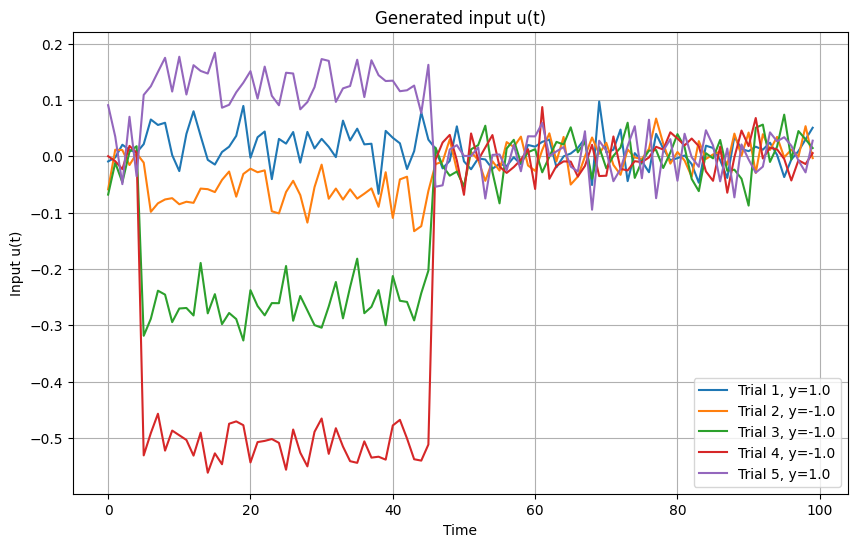

In [2]:
def create_input_data(time, noise_mean=0, noise_std=0.03):
    u = np.zeros(len(time))
    positive_magnitudes = (3.2 / 100) * np.array([1, 2, 4, 8, 16])
    possible_stimulus_strengths = np.sort(np.concatenate([-positive_magnitudes, positive_magnitudes]))
    stimulus_strength = np.random.choice(possible_stimulus_strengths)
    for t in time:
        xi = np.random.normal(noise_mean, noise_std)
        if 5 <= t <= 45:
            u[t] = stimulus_strength + xi
        else:
            u[t] = xi
    y = np.sign(stimulus_strength)
    return u, y

def create_input_dataframe_multiple_trials(time, trials=100):
    data = []
    for _ in range(trials):
        u, y = create_input_data(time)
        data.append({'u': u, 'y': y})
    df = pd.DataFrame(data)
    return df

t = np.arange(0, 100)
input = create_input_dataframe_multiple_trials(t, trials=5)


plt.figure(figsize=(10, 6))
for i in range(len(input)):
    plt.plot(t, input['u'][i], label=f'Trial {i+1}, y={input["y"][i]}')
plt.xlabel('Time')
plt.ylabel('Input u(t)')
plt.title('Generated input u(t)')
plt.legend()
plt.grid(True)
plt.show()

## 2. Recurrent Neural Network Initialization

Implement the recurrent neural network in your favorite deep learning library. The network has one-dimensional inputs and outputs, and an arbitrary number N of recurrent units. Its trainable parameters are the left and right connectivity vectors m, n. It also has fixed input and output weights I and w, respectively. All (trainable and fixed) parameters are sampled from a standard normal distribution, with the exception of the output weights, which are drawn with standard deviation of 4 (why?). The dynamics of the ith unit are given by

$
\tau \frac{dx_i}{dt} = -x_i + \sum_{j=1}^N J_{ij} \phi(x_j) + I_i u(t), \quad i = 1, \ldots, N.
$

Here $\Phi= \tanh$ is the neuron’s transfer function, and $\tau = 100$ ms the neuronal time constant. Simulate the network using forward Euler with a time step of $\Delta t = 20$ ms (the stimulus duration of 75 time steps corresponds to 1500ms real time). The rank one matrix J is defined as

$
J = \frac{1}{N}\, \mathbf{m} \mathbf{n}^T
$

The network’s output is a linear readout of the rates:

$
z(t) = \frac{1}{N} \sum_{i=1}^N w_i \Phi(x_i)
$

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device(
    'cuda' if torch.cuda.is_available() else 
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)

class RankOneRNN(nn.Module):
    def __init__(self, N):
        super(RankOneRNN, self).__init__()
        self.N = N
        self.m = nn.Parameter(torch.randn(self.N, 1).to(device))
        self.n = nn.Parameter(torch.randn(self.N, 1).to(device))
        self.I = torch.randn(N).to(device)  
        self.w = torch.randn(N).to(device) * 4  # std=4

        self.tau = 100
        self.dt = 20

    def forward(self, u_batch):
        B, T = u_batch.shape
        x = torch.zeros(B, self.N).to(device)
        z_out = []

        for t in range(T):
            phi_x = torch.tanh(x)
            J_phi = (1 / self.N) * (phi_x @ self.n) * self.m.T
            u_t = u_batch[:, t]
            du = (-x + J_phi + self.I * u_t.unsqueeze(1)) * (self.dt / self.tau)
            x = x + du
            z_t = (1 / self.N) * (phi_x @ self.w)
            z_out.append(z_t)

        z_out = torch.stack(z_out, dim=1)
        return z_out

## 3. Training the network

Train a network of size N = 1281 by minimizing the mean squared error

$
\frac{1}{BT} \sum_{i, t} (z_i(t) - y_i(t))^2
$

using stochastic gradient descent. Here, the sum runs over all B trials in a mini-batch and the last T = 15 time steps (the target is only defined during this last ’decision epoch’). Use Adam with a learning rate of 5e-3 and a batch size of 32. The loss should converge to a value below 5e-2, which might require 1000 parameter updates. If the loss converges to higher values, debug your code by (1) overfitting the network on a single batch, and (2) training a full-rank network. Make sure to look at the the network’s input, output, and hidden dynamics once it has successfully converged.



In [4]:
def get_batch(time, batch_size):
    df = create_input_dataframe_multiple_trials(time, trials=batch_size)
    u = np.stack(df['u'].values)
    y = np.array(df['y'].values)
    return torch.tensor(u, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

N = 1000
batch_size = 32
lr = 5e-3
loss_threshold = 5e-2
T_total = 100
T_decision = 15
num_updates = 1000

model = RankOneRNN(N).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

losses = []
for step in range(num_updates):
    u_batch, y_batch = get_batch(np.arange(0, T_total), batch_size)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)

    z_batch = model(u_batch)
    z_decision = z_batch[:, -T_decision:]
    y_expanded = y_batch.unsqueeze(1).expand_as(z_decision)

    loss = loss_fn(z_decision, y_expanded)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    losses.append(loss_val)
    
    if loss_val < loss_threshold:
        print(f"Early stopping at step {step}, Loss: {loss_val:.4f}")
        break

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss_val:.4f}")

Step 0, Loss: 0.9989
Step 100, Loss: 1.0009
Early stopping at step 193, Loss: 0.0437


## 4. Analysis of the network

We now have a neural network model that performs perceptual decision-making, but this is only a first step. Next, we want to understand how this model works, to generate
hypotheses how the brain might perform analogous functions. Dubreuil et al.[3] found that their network relied on a specific pattern of correlations between the connectivity vectors (their figure 2b). Explain why this pattern works for the task, and compare it
with the pattern in your network.


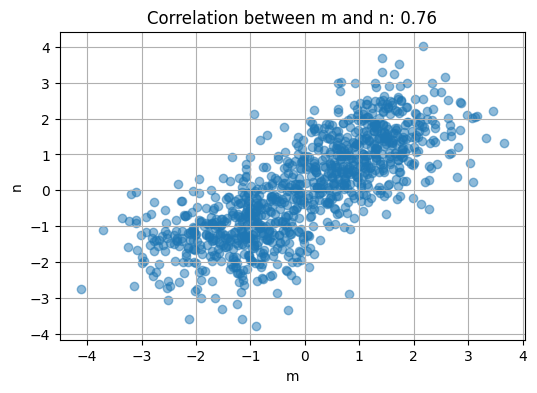

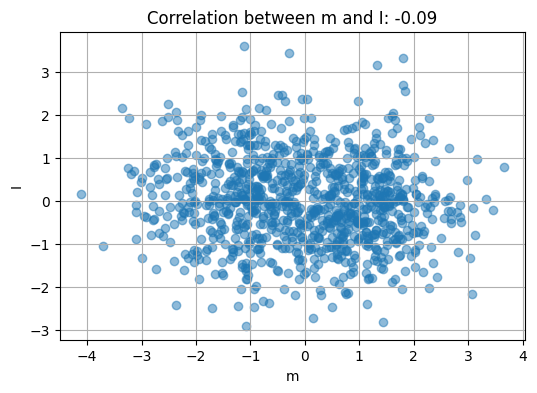

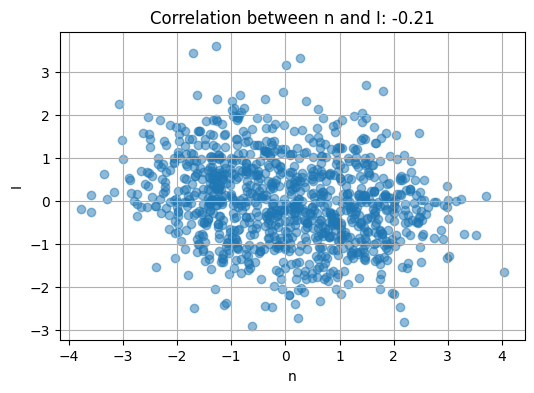

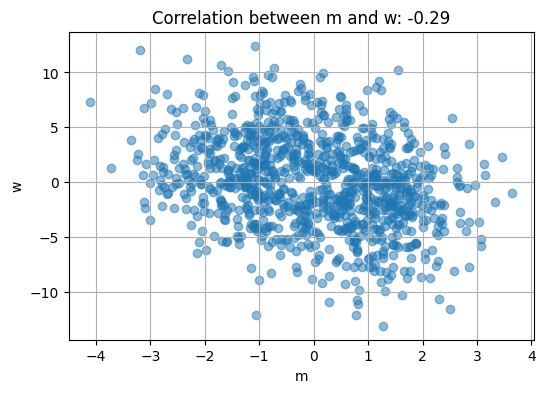

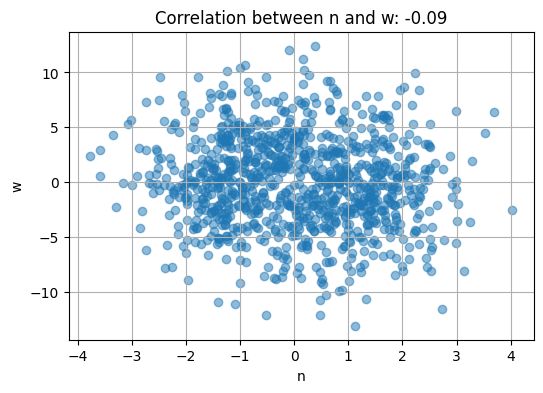

In [5]:
def plot_correlation(x, y, xlabel, ylabel, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

m_np = model.m.detach().cpu().numpy().flatten()
n_np = model.n.detach().cpu().numpy().flatten()
I_np = model.I.detach().cpu().numpy()
w_np = model.w.detach().cpu().numpy()

mn = np.corrcoef(m_np, n_np)[0, 1]
mI = np.corrcoef(m_np, I_np)[0, 1]
nI = np.corrcoef(n_np, I_np)[0, 1]
mw = np.corrcoef(m_np, w_np)[0, 1]
nw = np.corrcoef(n_np, w_np)[0, 1]

plot_correlation(m_np, n_np, 'm', 'n', f'Correlation between m and n: {mn:.2f}')
plot_correlation(m_np, I_np, 'm', 'I', f'Correlation between m and I: {mI:.2f}')
plot_correlation(n_np, I_np, 'n', 'I', f'Correlation between n and I: {nI:.2f}')
plot_correlation(m_np, w_np, 'm', 'w', f'Correlation between m and w: {mw:.2f}')
plot_correlation(n_np, w_np, 'n', 'w', f'Correlation between n and w: {nw:.2f}')

This finding is useful, because now we know that the connectivity vectors m and n can be reduced to a single vector later.

## 5. Gaussian approximation

The theory of low-rank networks relies on Gaussian approximations (see methods and supplements of [3]), which characterizes connectivity vectors by their second order statistics. Test if this assumption holds in your trained network by (1) fitting a 4-dimensional Gaussian distribution to the connectivity vectors, (2) Resampling from the fitted distribution, (3) Comparing the empirical with the resampled distribution, and (4) Testing networks with the resampled connectivity by comparing the sign of the output with the sign of the target.

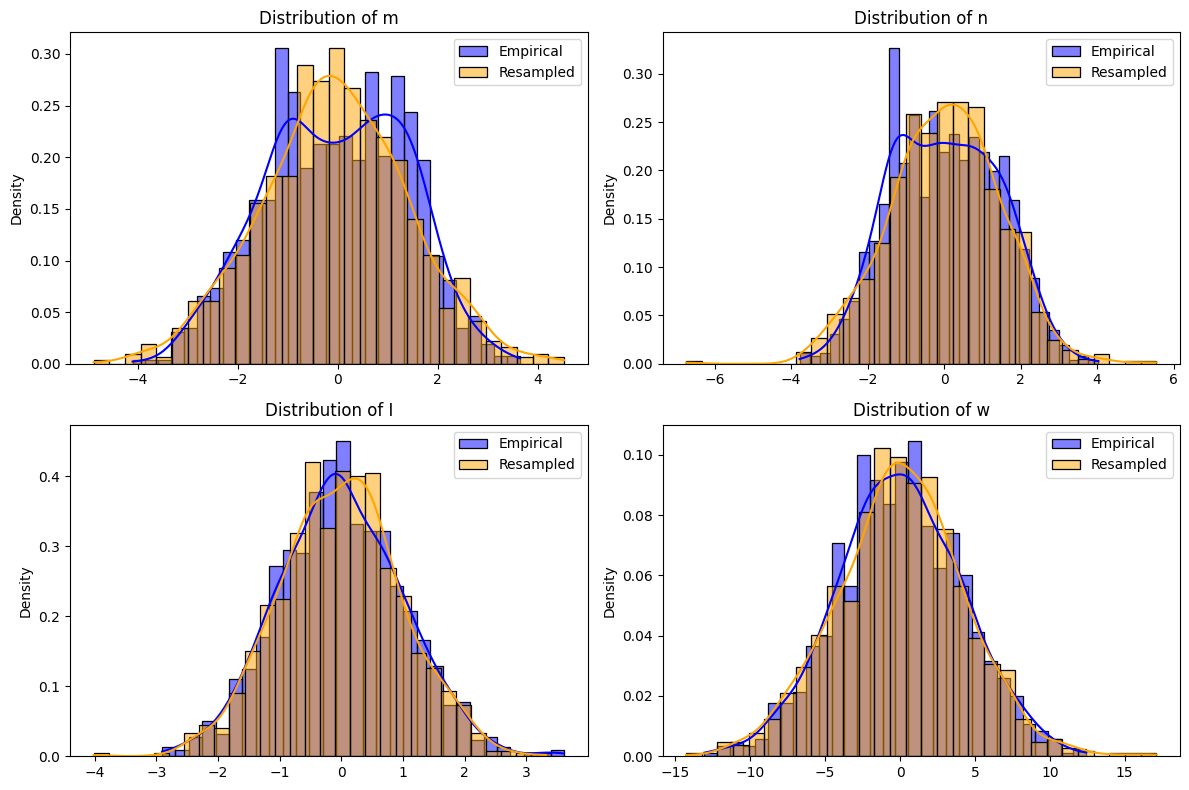

Classification accuracy (resampled connectivity): 100.00%


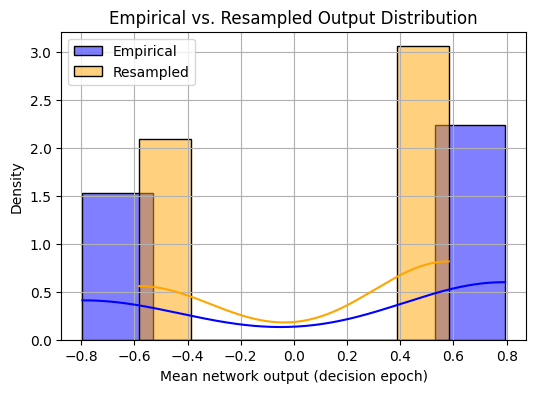

In [6]:
import seaborn as sns

param_names = ['m', 'n', 'I', 'w']
params = [
    getattr(model, name).detach().cpu().numpy().flatten() 
    for name in param_names
]
X = np.stack(params, axis=1)

mean = X.mean(axis=0)
cov = np.cov(X, rowvar=False)

z_decision_np = z_decision.detach().cpu().numpy()
y_expanded_np = y_expanded.detach().cpu().numpy()
mean_z = z_decision_np.mean(axis=1)     
target_sign = y_expanded_np[:, 0]       

N = X.shape[0]
X_resampled = np.random.multivariate_normal(mean, cov, size=N)
m_resampled, n_resampled, I_resampled, w_resampled = [X_resampled[:, i] for i in range(4)]

# 3. Compare empirical and resampled distributions
plt.figure(figsize=(12, 8))
for i, name in enumerate(param_names):
    plt.subplot(2, 2, i+1)
    sns.histplot(X[:, i], color='blue', label='Empirical', kde=True, stat='density', bins=30)
    sns.histplot(X_resampled[:, i], color='orange', label='Resampled', kde=True, stat='density', bins=30, alpha=0.5)
    plt.title(f'Distribution of {name}')
    plt.legend()
plt.tight_layout()
plt.show()

# 4. Test network with resampled connectivity
model_gauss = RankOneRNN(N).to(device)
model_gauss.m = nn.Parameter(torch.tensor(m_resampled, dtype=torch.float32, device=device).unsqueeze(1))
model_gauss.n = nn.Parameter(torch.tensor(n_resampled, dtype=torch.float32, device=device).unsqueeze(1))
model_gauss.I = torch.tensor(I_resampled, dtype=torch.float32, device=device)
model_gauss.w = torch.tensor(w_resampled, dtype=torch.float32, device=device)

# Use the same batch as before for fair comparison
with torch.no_grad():
    z_batch_gauss = model_gauss(u_batch)
    z_decision_gauss = z_batch_gauss[:, -z_decision_np.shape[1]:].cpu().numpy()
    mean_z_gauss = z_decision_gauss.mean(axis=1)
    pred_sign_gauss = np.sign(mean_z_gauss)
    accuracy_gauss = np.mean(pred_sign_gauss == target_sign)
    print(f"Classification accuracy (resampled connectivity): {accuracy_gauss:.2%}")

# Compare output distributions
plt.figure(figsize=(6, 4))
sns.histplot(mean_z, color='blue', label='Empirical', kde=True, stat='density')
sns.histplot(mean_z_gauss, color='orange', label='Resampled', kde=True, stat='density', alpha=0.5)
plt.xlabel('Mean network output (decision epoch)')
plt.title('Empirical vs. Resampled Output Distribution')
plt.legend()
plt.grid(True)
plt.show()

Basically, we define the 4-dimensional vector space spanned by the connectivity vectors m, n, I, and w. Then, we resample from the fitted Gaussian distribution, and evaluation gives us the same accuracy as before. This shows that the first-order and second-order statistics of the connectivity patterns are expressive enough to capture the information we need for decision-making, and there is no one sharp solution for this task. It is like a voting system, where the overall output is contributed by single neural connections.

Recall Chapman-Kolmogorov expansions: If we have infinitely many addition terms in the Taylor expansion, we can approximate any infinitely sharp distribution with arbitrary spikes. But if we know the underlying manifold is smooth in a Gaussian style, we can approximate it using a second-order Taylor expansion with gradient and Hessian information.

## 6. Dimensionality reduction

The dynamics of our model are low-dimensional, making dimensionality reduction [2] a promising approach. In this case, we already know the 2-dimensional space in which the dynamics live: it is spanned by the input vector I and the left-connectivity vector m (why?). Confirm this by projecting the N dimensional, time-varying dynamics x(t) onto the m −I plane. Do the dynamics of different trials evolve in an interpretable manner? How could you reduce the dimensionality if you did not know m and I, as would be the case with an arbitrary RNN, or with experimental data?


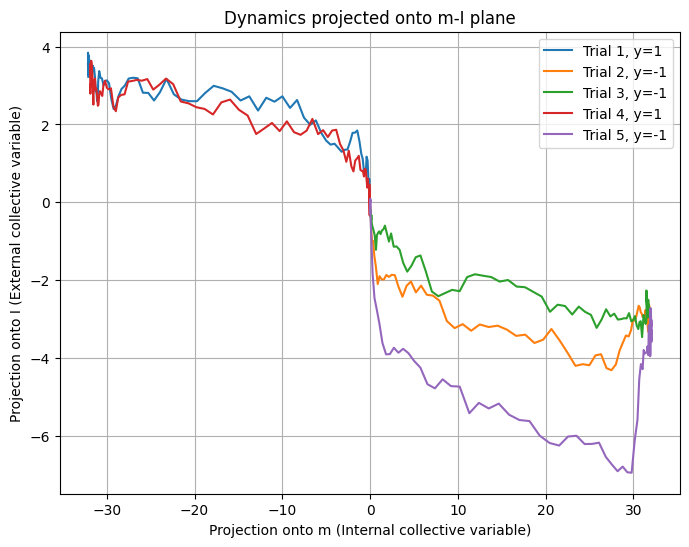

In [7]:
num_trials = 5
T_total = 100

u_batch, y_batch = get_batch(np.arange(0, T_total), num_trials)
u_batch = u_batch.to(device)

def get_hidden_states(model, u_batch):
    B, T = u_batch.shape
    x = torch.zeros(B, model.N).to(device)
    xs = []
    for t in range(T):
        phi_x = torch.tanh(x)
        J_phi = (1 / model.N) * (phi_x @ model.n) * model.m.T
        u_t = u_batch[:, t]
        du = (-x + J_phi + model.I * u_t.unsqueeze(1)) * (model.dt / model.tau)
        x = x + du
        xs.append(x.detach().cpu().numpy())
    xs = np.stack(xs, axis=1)
    return xs

xs = get_hidden_states(model, u_batch)

m_np = model.m.detach().cpu().numpy().flatten()
I_np = model.I.detach().cpu().numpy().flatten()
m_norm = m_np / np.linalg.norm(m_np)
I_norm = I_np / np.linalg.norm(I_np)

kappa = np.dot(xs, m_norm)
upsilon = np.dot(xs, I_norm)

plt.figure(figsize=(8, 6))
for i in range(num_trials):
    plt.plot(kappa[i], upsilon[i], label=f'Trial {i+1}, y={y_batch[i].item():.0f}')
plt.xlabel('Projection onto m (Internal collective variable)')
plt.ylabel('Projection onto I (External collective variable)')
plt.title('Dynamics projected onto m-I plane')
plt.legend()
plt.grid(True)
plt.show()

Here, we project the hidden state dynamics x(t) onto the m-I plane for several trials (5).

From the paper, we know that the internal variable $\kappa$ encodes the integrated stimulus and could be directly interpreted in terms of the computation performed by the network. If $y$ is positive, $\kappa$ should be positive, and vice versa. This plot clearly indicates that the network performs the task correctly.

## 7. Distill trained model

Using the Gaussian assumption, we are ready for the final step: distilling the trained network into an equivalent one-dimensional dynamical system of the form

$$
\tau \frac{d\kappa}{dt} = -\kappa(t) + \tilde{\sigma}_{mn} \kappa(t) + \tilde{\sigma}_{nI} v(t),
$$

where $\kappa$ is the latent variable $\kappa(t) = \frac{1}{\|\mathbf{m}\|} \mathbf{m}^T \mathbf{x}(t)$ and $v$ the external inputs filtered by the neuronal time constant:

$$
\tau \frac{dv}{dt} = -v(t) + u(t).
$$

Note that these equations assume that $\mathbf{m}$ and $\mathbf{I}$ are orthogonal. Each coupling term $\tilde{\sigma}_{ab}$ is the product $\sigma_{ab} \langle \Phi' \rangle(\Delta)$ of the corresponding covariance and the neuronal gain, averaged over the Gaussian statistics of the population:

$$
\langle \Phi' \rangle(\Delta) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \phi'(\Delta z) e^{-z^2/2} dz.
$$

Here, $\Delta$ captures the system’s non-linearity because it depends on the state $\kappa$ and inputs $v$:

$$
\Delta = \sqrt{\sigma_m^2 \kappa^2 + \sigma_I^2 u^2}.
$$
First, compute the necessary covariances $\sigma_{mn}$, $\sigma_{nI}$ etc. from your trained network. Then, use these to simulate the low-dimensional dynamics $\frac{d\kappa}{dt}$. You can use scipy’s quadrature function to integrate the Gaussian integral. Does the equivalent circuit indeed perform the task? If it does not, try using the covariances given in the paper: $\sigma_{mn} = 1.4$, $\sigma_{nI} = 2.6$, $\sigma_{mw} = 2.1$, and $\sigma_{w} = \sigma_{n} = \sigma_{I} = 1$.


Low-dimensional circuit accuracy: 100.00%


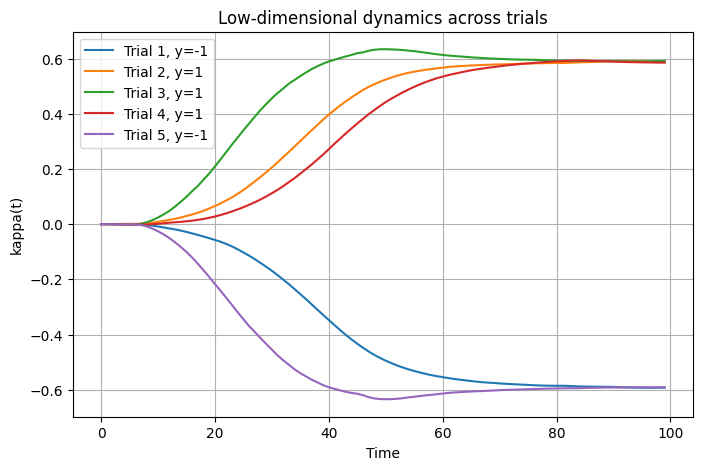

In [8]:
from scipy import integrate

params = [
    getattr(model, name).detach().cpu().numpy().flatten() 
    for name in param_names
]
m_np, n_np, I_np, w_np = params

sigma_m, _, sigma_I, _ = [np.std(p) for p in params]
sigma_mn, sigma_nI = [
    np.cov(params[i], params[(i+1) % len(params)])[0, 1]
    for i in range(len(params) - 2)
]

assert np.abs(np.cov(m_np, I_np)[0, 1]) <= 0.15, f"m and I should be (almost) orthogonal, but got {np.cov(m_np, I_np)[0, 1]:.2f}"

def phi_prime(z):
    return 1 - np.tanh(z)**2

def mean_phi_prime(Delta):
    integrand = lambda z: phi_prime(Delta * z) * np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)
    val, _ = integrate.quad(integrand, -8, 8)
    return val

def simulate_low_dim(u, dt=20, tau=100, kappa0=0, v0=0):
    T = len(u)
    kappa = np.zeros(T)
    v = np.zeros(T)
    kappa[0] = kappa0
    v[0] = v0
    for t in range(1, T):
        dv = (-v[t-1] + u[t-1]) * (dt / tau)
        v[t] = v[t-1] + dv

        Delta = np.sqrt(sigma_m**2 * kappa[t-1]**2 + sigma_I**2 * u[t-1]**2)
        gain = mean_phi_prime(Delta)

        sigma_mn_eff = sigma_mn * gain
        sigma_nI_eff = sigma_nI * gain

        dkappa = (-kappa[t-1] + sigma_mn_eff * kappa[t-1] + sigma_nI_eff * v[t-1]) * (dt / tau)
        kappa[t] = kappa[t-1] + dkappa
    return np.sign(sigma_nI) * kappa, v

num_trials = 5
T_total = 100
u_batch, y_batch = get_batch(np.arange(0, T_total), num_trials)
u_batch_np = u_batch.cpu().numpy()

kappa_all = []
for i in range(num_trials):
    kappa, v = simulate_low_dim(u_batch_np[i])
    kappa_all.append(kappa)

kappa_all = np.stack(kappa_all)

T_decision = 15
mean_kappa = kappa_all[:, -T_decision:].mean(axis=1)
pred_sign = np.sign(mean_kappa)
target_sign = y_batch.cpu().numpy()
accuracy = np.mean(pred_sign == target_sign)
print(f"Low-dimensional circuit accuracy: {accuracy:.2%}")

plt.figure(figsize=(8, 5))
for i in range(num_trials):
    plt.plot(kappa_all[i], label=f'Trial {i+1}, y={int(target_sign[i])}')
plt.xlabel('Time')
plt.ylabel('kappa(t)')
plt.title('Low-dimensional dynamics across trials')
plt.legend()
plt.grid(True)
plt.show()

Based on the previous exercise (where we find out that the internal collective variable integrates the results perfectly accurately), we can now distill the trained network into a low-dimensional dynamic system capturing the essential computations. 

## 8. Fixed point analysis

A complementary way of reverse-engineering a trained RNN is to analyze its locally linear dynamics around fixed points [9]. This is a standard approach in low-dimensional systems, done numerically when applied to RNNs. Find the fixed points of the low-dimensional circuit by minimizing the energy $q = \frac{1}{2} \left(\frac{d\kappa}{dt}\right)^2$ over $\kappa$ for zero input (note that this is not the second derivative!). You can use scipy’s `minimize` for this. How would the result change in a circuit that integrates the exact value of its input, rather than the sign?


Fixed point (kappa*): 0.00


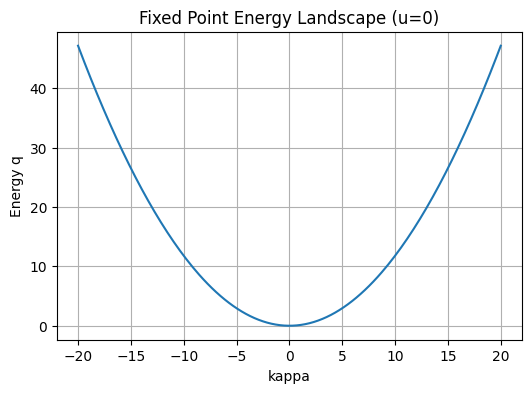

In [19]:
from scipy.optimize import minimize

def fixed_point_energy(kappa, sigma_mn, gain, sigma_nI, v):
    dkappa = (-kappa + sigma_mn * gain * kappa + sigma_nI * v)
    return 0.5 * dkappa**2

Delta0 = 0.0
gain0 = mean_phi_prime(Delta0)

sigma_mn_eff = sigma_mn
sigma_nI_eff = sigma_nI
v = 0.0

res = minimize(fixed_point_energy, x0=0.0, args=(sigma_mn_eff, gain0, sigma_nI_eff, v))
kappa_star = res.x[0]
print(f"Fixed point (kappa*): {kappa_star:.2f}")

kappa_range = np.linspace(-20, 20, 200)
energy = [fixed_point_energy(k, sigma_mn_eff, gain0, sigma_nI_eff, v) for k in kappa_range]
plt.figure(figsize=(6,4))
plt.plot(kappa_range, energy)
plt.xlabel('kappa')
plt.ylabel('Energy q')
plt.title('Fixed Point Energy Landscape (u=0)')
plt.grid(True)
plt.show()

Now, we can compare with the case where the circuit integrates the exact value of its input. For a perfect integrator: $\frac{d\kappa}{dt} = u(t)$, so at $u=0$ when input is zero, any kappa can be a fixed point.

# 3. Parametric Working Memory

Most computations happen in more than one dimension. Here, we will look at such a computation by modeling parametric working memory (see Figure 3 from Dubreuil et al. [3]). The different steps in this exercise are analogous to those in the first exercise. The goal is to:

1. See how the low rank framework applies to networks with rank two.
2. Get more practice with training and reverse-engineering RNNs without relying on the strict instructions from exercise 1.


## 1. Data Generation

Create a function for generating the data. Both the input $u$ and the target output $y$ are again one-dimensional. The input now consists of a first stimulus, followed by a delay and the second stimulus:

$$
u(t) = 
\begin{cases}
u_1 & \text{if } 5 \leq t \leq 10 \\
u_2 & \text{if } 60 \leq t \leq 70 \\
0 & \text{otherwise}
\end{cases}
$$

The two stimuli are defined as

$$
u_i = \frac{1}{f_{\max} - f_{\min}} \left( f_i - \frac{f_{\max} + f_{\min}}{2} \right), \quad i = 1,2
$$

with $f_i$ sampled uniformly from the set $\{10, 14, 18, 22, 26, 30, 34\}$, and $f_{\min} = 10$, $f_{\max} = 34$ the smallest and largest elements of that set. The target output $y$ is the normalized difference between the stimuli:

$$
y = \frac{f_1 - f_2}{f_{\max} - f_{\min}}
$$

Note: In the paper, they use random delays and more points $f_i$. Discuss how that potentially affects the solution.

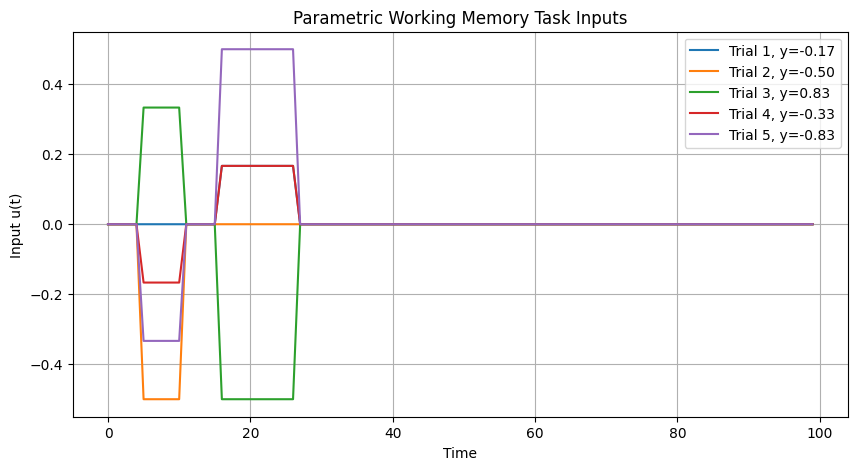

In [31]:
def generate_parametric_memory_trial_with_delay(time, delay):
    freq_set = np.array([10, 14, 18, 22, 26, 30, 34])
    f_min, f_max = freq_set.min(), freq_set.max()
    norm = f_max - f_min
    f1, f2 = np.random.choice(freq_set, size=2, replace=True)
    u1 = (f1 - (f_max + f_min) / 2) / norm
    u2 = (f2 - (f_max + f_min) / 2) / norm

    u = np.zeros(len(time))
    u[(time >= 5) & (time <= 10)] = u1
    stim2_start = 11 + delay
    stim2_end = stim2_start + 10
    u[(time >= stim2_start) & (time <= stim2_end)] = u2

    y = (f1 - f2) / norm
    return u, y

def generate_parametric_memory_batch_with_delay(time, delay, trials=32):
    us = []
    ys = []
    for _ in range(trials):
        u, y = generate_parametric_memory_trial_with_delay(time, delay)
        us.append(u)
        ys.append(y)
    u_batch = np.stack(us)
    y_batch = np.array(ys)
    return torch.tensor(u_batch, dtype=torch.float32), torch.tensor(y_batch, dtype=torch.float32)

t = np.arange(0, 100)
u, y = generate_parametric_memory_batch_with_delay(t, delay=5, trials=5)

plt.figure(figsize=(10, 5))
for i in range(u.shape[0]):
    plt.plot(t, u[i].detach().cpu().numpy(), label=f'Trial {i+1}, y={y[i]:.2f}')
plt.xlabel('Time')
plt.ylabel('Input u(t)')
plt.title('Parametric Working Memory Task Inputs')
plt.legend()
plt.grid(True)
plt.show()


## 2. Network Implementation

Extend your network implementation to allow for recurrent connectivity of arbitrary rank.

In [32]:
class MultiRankRNN(nn.Module):
    def __init__(self, N, num_ranks=2):
        super().__init__()
        self.N = N
        self.num_ranks = num_ranks
        self.m = nn.Parameter(torch.randn(N, num_ranks).to(device))
        self.n = nn.Parameter(torch.randn(N, num_ranks).to(device))
        self.I = torch.randn(N).to(device)
        self.w = torch.randn(N).to(device) * 4
        self.tau = 100
        self.dt = 20

    def forward(self, u_batch):
        B, T = u_batch.shape
        x = torch.zeros(B, self.N, device=u_batch.device)
        z_out = []

        for t in range(T):
            phi_x = torch.tanh(x)
            J_phi = (1 / self.N) * (phi_x @ self.n) @ self.m.T
            u_t = u_batch[:, t].unsqueeze(1)
            du = (-x + J_phi + self.I * u_t) * (self.dt / self.tau)
            x = x + du
            z_t = (1 / self.N) * torch.tanh(x) @ self.w
            z_out.append(z_t)

        return torch.stack(z_out, dim=1)

## 3. Training

Train a network of size $N = 128$ and rank $R = 2$ by minimizing the mean squared error between the target and the network output during the last 5 time steps of each trial. The loss should drop below $5 \times 10^{-3}$. If it does not, make sure to visualize your data and the network's output, and try debugging the network using the tips from exercise 1. In addition, you can try a curriculum learning approach by gradually increasing the delay period between the two stimuli, starting from 25 time steps.

In [ ]:
min_delay = 10
max_delay = 50
delay_increment = 5
current_delay = min_delay
model = MultiRankRNN(N=128, num_ranks=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
loss_threshold = 5e-3

for step in range(5000):
    u_batch, y_batch = generate_parametric_memory_batch_with_delay(t, delay=current_delay, trials=32)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)

    z_batch = model(u_batch)
    z_decision = z_batch[:, -5:]
    y_target = y_batch.unsqueeze(1).expand(-1, 5)

    loss = loss_fn(z_decision, y_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0 or loss.item() < loss_threshold:
        print(f"Step {step} | Loss: {loss.item():.5f}")
        if loss.item() < loss_threshold:
            print("✅ Loss converged.")
            break


Step 0 | Loss: 0.20313
Step 100 | Loss: 0.23175
Step 200 | Loss: 0.18779
Step 300 | Loss: 0.20249
Step 400 | Loss: 0.19832
Step 500 | Loss: 0.13703
Step 600 | Loss: 0.14441
Step 700 | Loss: 0.09871
Step 800 | Loss: 0.03561
Step 900 | Loss: 0.03877
Step 1000 | Loss: 0.04376
Step 1100 | Loss: 0.02448
Step 1200 | Loss: 0.01701
Step 1300 | Loss: 0.03086
Step 1400 | Loss: 0.01732
Step 1500 | Loss: 0.02419


## 4. Connectivity Patterns

Visualize the connectivity patterns from the trained network, and compare with those reported by Dubreuil et al. (their Figure 3b). Why do these patterns work? Why could a rank 1 network not solve this task?

Correlation coefficients:
m1 vs m2: -0.286 (weak negative)
m1 vs n1: 0.517 (strong positive)
m1 vs n2: -0.041 (orthogonal)
m1 vs I: 0.077 (orthogonal)
m1 vs w: -0.241 (weak negative)
m2 vs n1: 0.075 (orthogonal)
m2 vs n2: 0.282 (weak positive)
m2 vs I: 0.036 (orthogonal)
m2 vs w: 0.494 (strong positive)
n1 vs n2: -0.083 (orthogonal)
n1 vs I: 0.378 (strong positive)
n1 vs w: 0.033 (orthogonal)
n2 vs I: -0.307 (weak negative)
n2 vs w: 0.117 (weak positive)
I vs w: 0.119 (weak positive)


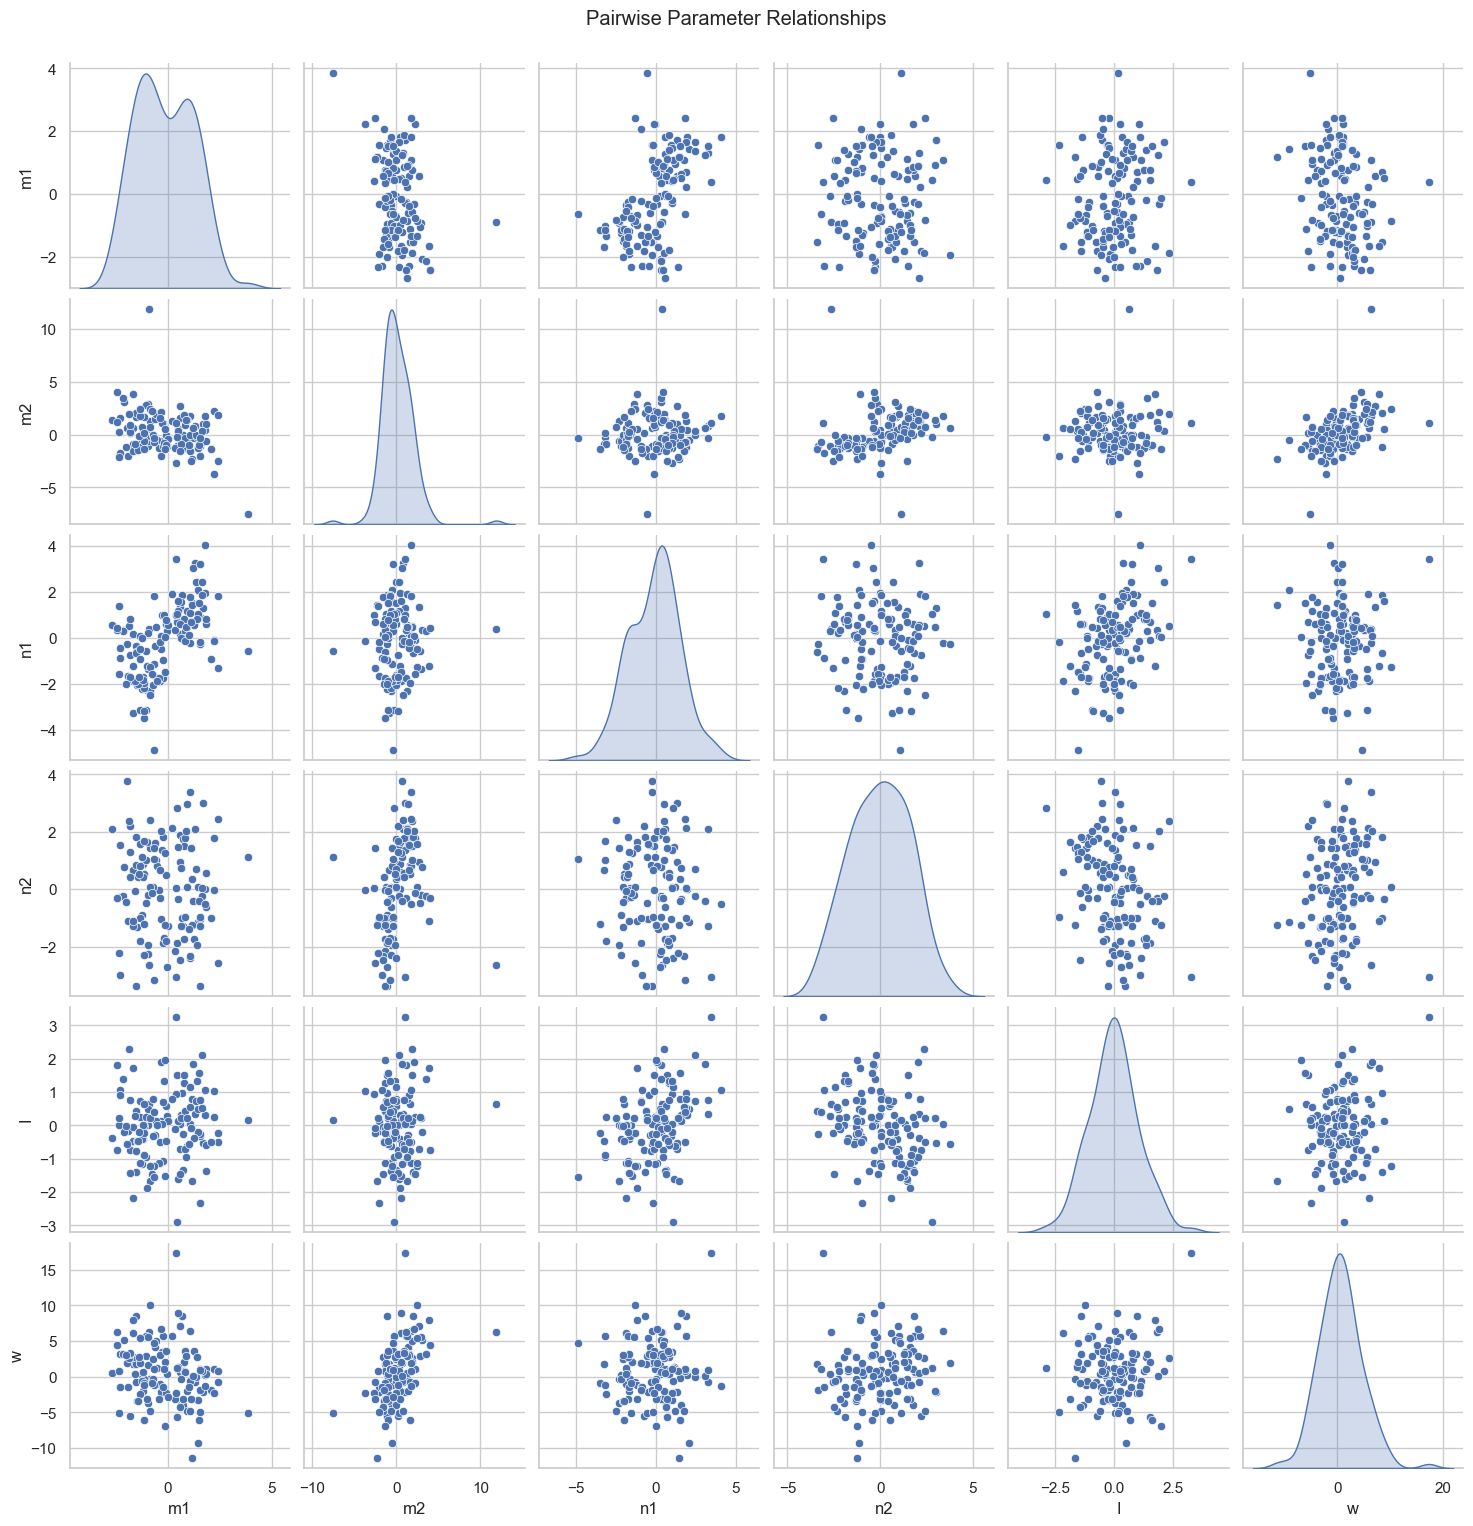

In [16]:
import seaborn as sns

m = model.m.detach().cpu().numpy()
n = model.n.detach().cpu().numpy()
I = model.I.detach().cpu().numpy()
w = model.w.detach().cpu().numpy()

m1, m2 = m[:, 0], m[:, 1]
n1, n2 = n[:, 0], n[:, 1]

all_params = np.stack([m1, m2, n1, n2, I, w], axis=1)

sns.set_theme(style="whitegrid")
df_params = pd.DataFrame(all_params, columns=['m1', 'm2', 'n1', 'n2', 'I', 'w'])
g = sns.pairplot(df_params, diag_kind='kde', markers='o')
plt.suptitle('Pairwise Parameter Relationships', y=1.02)

corr_matrix = df_params.corr()
print("Correlation coefficients:")
for i, col1 in enumerate(df_params.columns):
    for j, col2 in enumerate(df_params.columns):
        if i < j:
            corr = corr_matrix.loc[col1, col2]
            classification = "orthogonal"
            if corr > 0.35:
                classification = "strong positive"
            elif corr > 0.1:
                classification = "weak positive"
            if corr < -0.35:
                classification = "strong negative"
            elif corr < -0.1:
                classification = "weak negative"

            print(f"{col1} vs {col2}: {corr:.3f} ({classification})")

plt.show()

As we can see from the pair plots above, the relationships between parameters exhibit different patterns. Below are our findings:

- Different connectivity vectors across different modes $m_1-n_2$ and $m_2-n_1$ are orthogonal to each other.
- Different connectivity vectors within the same mode $m_1-n_1$ and $m_2-n_2$ are strongly correlated.
- Same connectivity vectors across different modes show a more differentiated behavior: Left $m_1-m_2$ indicates strong correlation, while $n_1-n_2$ is highly orthogonal.
- Most importantly, input $I$ and connectivity vectors $m_1, m_2$ exhibit orthogonal behavior, while $n_1, n_2$ are strongly correlated with the readout $w$.

The last one means we can reduce the dimensionality of the whole network to a three-dimensional space spanned by the orthogonal vectors $I$, $m_1$, and $m_2$.


## 5. Dimensionality Reduction

Project the $N$-dimensional activity onto the $m_1, m_2$ plane to obtain latent variables $\kappa_1, \kappa_2$. Does their activity show the two time scales you might expect from the connectivity patterns?

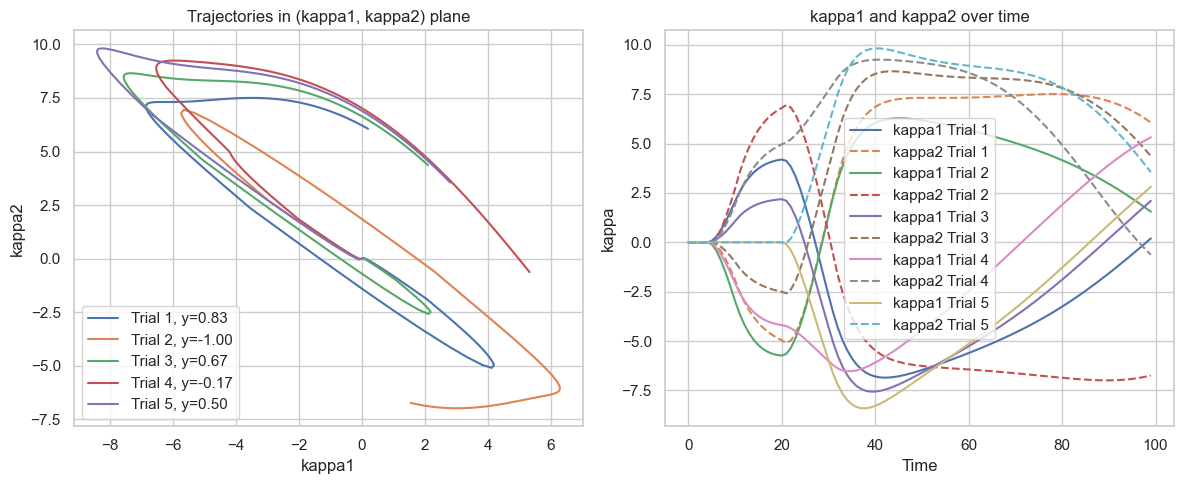

In [17]:
def get_hidden_states_multirank(model, u_batch):
    B, T = u_batch.shape
    x = torch.zeros(B, model.N, device=u_batch.device)
    xs = []
    for t in range(T):
        phi_x = torch.tanh(x)
        J_phi = (1 / model.N) * (phi_x @ model.n) @ model.m.T
        u_t = u_batch[:, t].unsqueeze(1)
        du = (-x + J_phi + model.I * u_t) * (model.dt / model.tau)
        x = x + du
        xs.append(x.detach().cpu().numpy())
    xs = np.stack(xs, axis=1)
    return xs

num_trials = 5
T_total = u_batch.shape[1]

t = np.arange(0, T_total)
u_batch, y_batch = generate_parametric_memory_batch_with_delay(t, delay=current_delay, trials=num_trials)
u_batch = u_batch.to(device)
y_batch = y_batch.to(device)

xs = get_hidden_states_multirank(model, u_batch)

m = model.m.detach().cpu().numpy()
m1 = m[:, 0]
m2 = m[:, 1]
m1_norm = m1 / np.linalg.norm(m1)
m2_norm = m2 / np.linalg.norm(m2)

kappa1 = np.dot(xs, m1_norm)
kappa2 = np.dot(xs, m2_norm)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i in range(num_trials):
    plt.plot(kappa1[i], kappa2[i], label=f'Trial {i+1}, y={y_batch[i]:.2f}')
plt.xlabel('kappa1')
plt.ylabel('kappa2')
plt.title('Trajectories in (kappa1, kappa2) plane')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(num_trials):
    plt.plot(kappa1[i], label=f'kappa1 Trial {i+1}')
    plt.plot(kappa2[i], '--', label=f'kappa2 Trial {i+1}')
plt.xlabel('Time')
plt.ylabel('kappa')
plt.title('kappa1 and kappa2 over time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

We observe that $\kappa_1$ and $\kappa_2$ exhibit different time scales, reflecting the two-rank structure: one stores the first stimulus, the other the second. This matches the expected connectivity-driven timescales.

## 6. Covariance Patterns

Test if the covariance patterns characterize the network connectivity by fitting and resampling a 6-dimensional Gaussian to the connectivity patterns.

> The (somewhat circuitous) definition of the stimuli is meant to evoke the working memory task developed by Romo et al. [7] in which subjects have to compare vibrotactile stimuli of different frequencies.

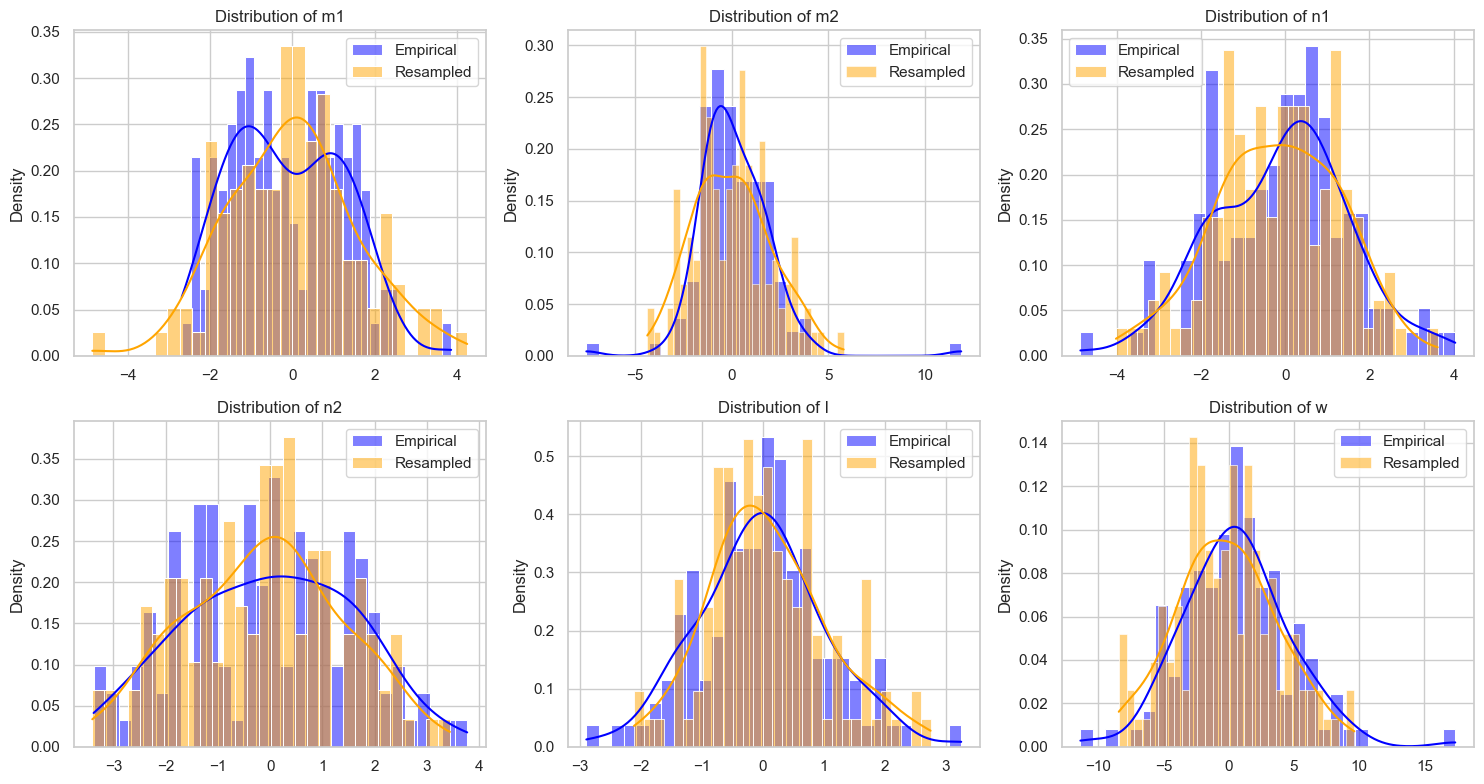

In [18]:
m, n, I, w = [
    getattr(model, name).detach().cpu().numpy() 
    for name in ['m', 'n', 'I', 'w']
]

X = np.column_stack([m[:,0], m[:,1], n[:,0], n[:,1], I, w])
param_names = ['m1', 'm2', 'n1', 'n2', 'I', 'w']

mean = X.mean(axis=0)
cov = np.cov(X, rowvar=False)

N = X.shape[0]
X_resampled = np.random.multivariate_normal(mean, cov, size=N)

plt.figure(figsize=(15, 8))
for i, name in enumerate(param_names):
    plt.subplot(2, 3, i+1)
    sns.histplot(X[:, i], color='blue', label='Empirical', kde=True, stat='density', bins=30)
    sns.histplot(X_resampled[:, i], color='orange', label='Resampled', kde=True, stat='density', bins=30, alpha=0.5)
    plt.title(f'Distribution of {name}')
    plt.legend()
plt.tight_layout()
plt.show()

Test MSE (resampled connectivity): 0.49774


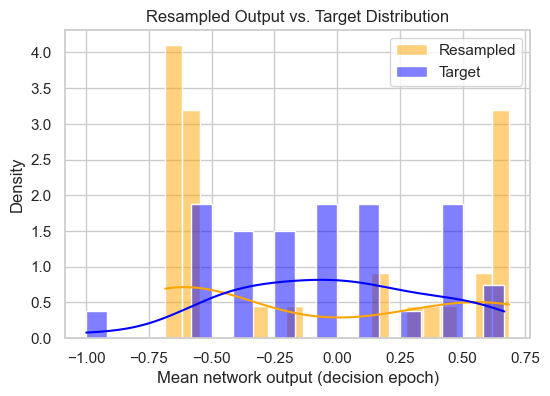

In [19]:
model_gauss = MultiRankRNN(N=N, num_ranks=2).to(device)
with torch.no_grad():
    m1, m2, n1, n2, I, w = [X_resampled[:, i] for i in range(6)]
    m = torch.tensor(np.column_stack([m1, m2]), dtype=torch.float32, device=device)
    n = torch.tensor(np.column_stack([n1, n2]), dtype=torch.float32, device=device)
    I = torch.tensor(I, dtype=torch.float32, device=device)
    w = torch.tensor(w, dtype=torch.float32, device=device)
    model_gauss.m.copy_(m)
    model_gauss.n.copy_(n)
    model_gauss.I.copy_(I)
    model_gauss.w.copy_(w)

u_batch, y_batch = generate_parametric_memory_batch_with_delay(t, delay=current_delay, trials=32)
u_batch = u_batch.to(device)
y_batch = y_batch.to(device)

with torch.no_grad():
    z_batch_gauss = model_gauss(u_batch)
    z_decision_gauss = z_batch_gauss[:, -5:]
    mean_z_gauss = z_decision_gauss.mean(dim=1).cpu().numpy()
    y_np = y_batch.cpu().numpy()
    mse = np.mean((mean_z_gauss - y_np) ** 2)
    print(f"Test MSE (resampled connectivity): {mse:.5f}")

plt.figure(figsize=(6, 4))
sns.histplot(mean_z_gauss, color='orange', label='Resampled', kde=True, stat='density', bins=20)
sns.histplot(y_np, color='blue', label='Target', kde=True, stat='density', bins=20, alpha=0.5)
plt.xlabel('Mean network output (decision epoch)')
plt.title('Resampled Output vs. Target Distribution')
plt.legend()
plt.grid(True)
plt.show()

## 7. Two-Dimensional Equivalent Circuit

Under the appropriate assumptions, the trained network can now be described by a two-dimensional equivalent circuit. Its dynamics are given by

$$
\frac{d\kappa_1}{dt} = -\kappa_1 + \tilde{\sigma}_{m_1 n_1} \kappa_1 + \tilde{\sigma}_{n_1 I} v(t)
$$

$$
\frac{d\kappa_2}{dt} = -\kappa_2 + \tilde{\sigma}_{m_2 n_2} \kappa_2 + \tilde{\sigma}_{n_2 I} v(t)
$$

The coupling terms again encapsulate the system’s nonlinearity, here via the scaling

$$
\Delta = \sqrt{\sigma_{m_1}^2 \kappa_1^2 + \sigma_{m_2}^2 \kappa_2^2 + \sigma_I^2 v^2}
$$

Simulate the effective circuit for different inputs $v$. The circuit should perform qualitatively, but not necessarily quantitatively, the same as the full network. If it does not, try using the covariances reported in the paper: $\sigma_{n_1 m_1} = 1$, $\sigma_{n_2 m_2} = 0.5$, $\sigma_{n_1 I} = 0.5$, $\sigma_{n_2 I} = 1.9$, $\sigma_{m_1 w} = 2.8$, $\sigma_{m_2 w} = -2.2$.

In [28]:
from scipy import integrate

m, n, I, w = [
    getattr(model, name).detach().cpu().numpy() 
    for name in ['m', 'n', 'I', 'w']
]

m1, m2 = m[:, 0], m[:, 1]
n1, n2 = n[:, 0], n[:, 1]

params = np.column_stack([m1, m2, n1, n2, I, w])

sigma_m1, sigma_m2, sigma_n1, sigma_n2, sigma_I, sigma_w = [
    np.std(params[:, i]) for i in range(6)
]

sigma_m1n1 = np.cov(m[:, 0], n[:, 0])[0, 1]
sigma_m2n2 = np.cov(m[:, 1], n[:, 1])[0, 1]
sigma_n1I = np.cov(n[:, 0], I)[0, 1]
sigma_n2I = np.cov(n[:, 1], I)[0, 1]

def phi_prime(z):
    return 1 - np.tanh(z)**2

def mean_phi_prime(Delta):
    integrand = lambda z: phi_prime(Delta * z) * np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)
    val, _ = integrate.quad(integrand, -8, 8)
    return val

def simulate_2d_equiv(u, dt=20, tau=100, kappa0=(0,0), v0=0,
                      sigma_m1n1=None, sigma_m2n2=None, sigma_n1I=None, sigma_n2I=None,
                      sigma_m1=None, sigma_m2=None, sigma_I=None):
    T = len(u)
    kappa1 = np.zeros(T)
    kappa2 = np.zeros(T)
    v = np.zeros(T)
    kappa1[0], kappa2[0] = kappa0
    v[0] = v0
    for t in range(1, T):
        dv = (-v[t-1] + u[t-1]) * (dt / tau)
        v[t] = v[t-1] + dv

        Delta = np.sqrt((sigma_m1**2) * kappa1[t-1]**2 + (sigma_m2**2) * kappa2[t-1]**2 + (sigma_I**2) * v[t-1]**2)
        gain = mean_phi_prime(Delta)

        sm1n1_eff = sigma_m1n1 * gain
        sm2n2_eff = sigma_m2n2 * gain
        sn1I_eff = sigma_n1I * gain
        sn2I_eff = sigma_n2I * gain

        dkappa1 = (-kappa1[t-1] + sm1n1_eff * kappa1[t-1] + sn1I_eff * v[t-1]) * (dt / tau)
        dkappa2 = (-kappa2[t-1] + sm2n2_eff * kappa2[t-1] + sn2I_eff * v[t-1]) * (dt / tau)
        kappa1[t] = kappa1[t-1] + dkappa1
        kappa2[t] = kappa2[t-1] + dkappa2
    return kappa1, kappa2, v


In [29]:
num_trials = 5
T_total = z_batch.shape[1]
if 'u_batch' not in locals():
    t = np.arange(0, T_total)
    u_batch, y_batch = generate_parametric_memory_batch_with_delay(t, delay=current_delay, trials=num_trials)
    u_batch = u_batch.to(device)
    y_batch = y_batch.to(device)
else:
    t = np.arange(0, u_batch.shape[1])

u_batch_np = u_batch.cpu().numpy()

kappa1_all = []
kappa2_all = []
for i in range(num_trials):
    k1, k2, v = simulate_2d_equiv(
        u_batch_np[i],
        sigma_m1n1=sigma_m1n1, sigma_m2n2=sigma_m2n2,
        sigma_n1I=sigma_n1I, sigma_n2I=sigma_n2I,
        sigma_m1=sigma_m1, sigma_m2=sigma_m2, sigma_I=sigma_I
    )
    kappa1_all.append(k1)
    kappa2_all.append(k2)
kappa1_all = np.stack(kappa1_all)
kappa2_all = np.stack(kappa2_all)

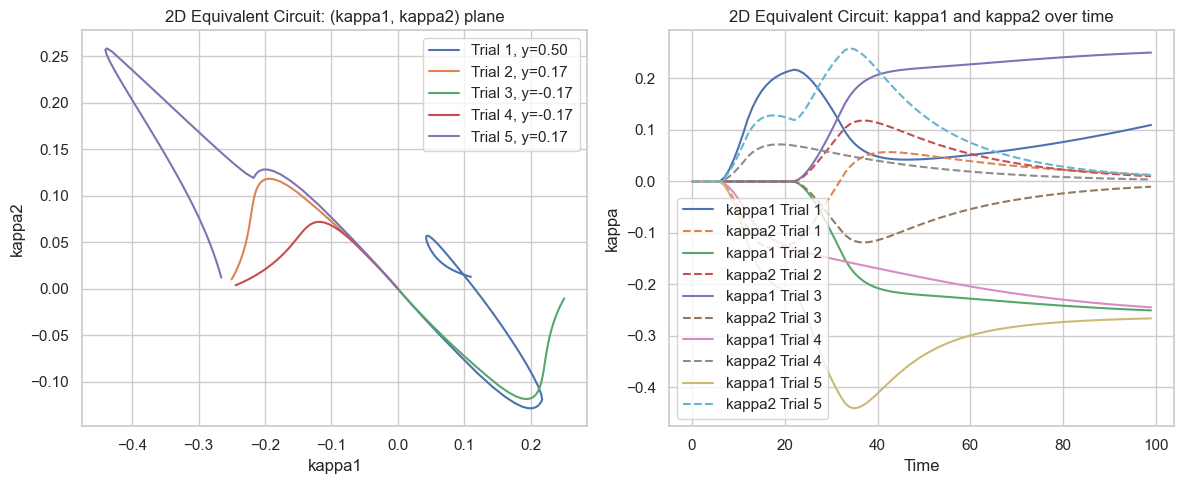

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(num_trials):
    plt.plot(kappa1_all[i], kappa2_all[i], label=f'Trial {i+1}, y={y_batch[i]:.2f}')
plt.xlabel('kappa1')
plt.ylabel('kappa2')
plt.title('2D Equivalent Circuit: (kappa1, kappa2) plane')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(num_trials):
    plt.plot(kappa1_all[i], label=f'kappa1 Trial {i+1}')
    plt.plot(kappa2_all[i], '--', label=f'kappa2 Trial {i+1}')
plt.xlabel('Time')
plt.ylabel('kappa')
plt.title('2D Equivalent Circuit: kappa1 and kappa2 over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

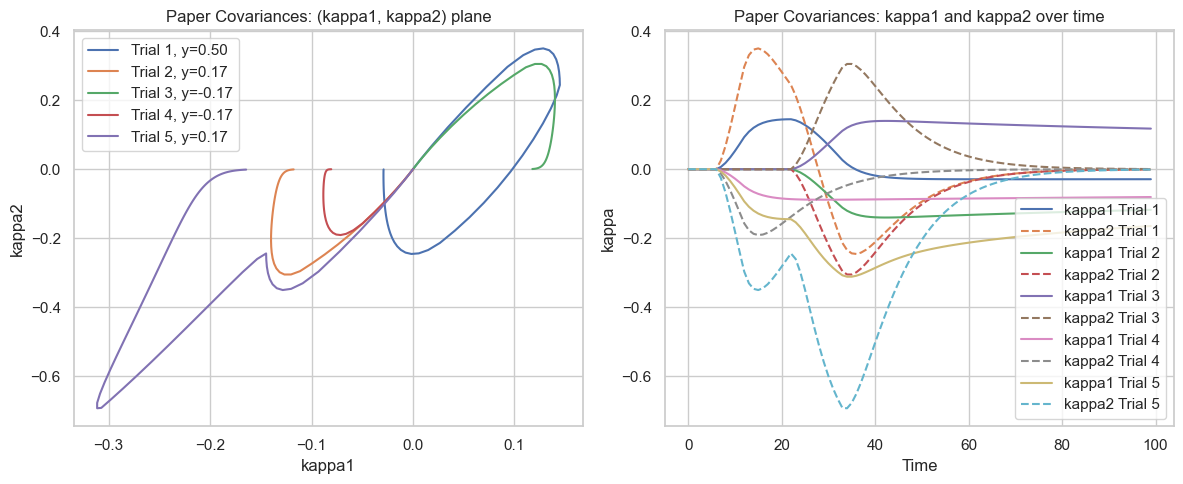

In [31]:
# Paper: sigma_{n1m1}=1, sigma_{n2m2}=0.5, sigma_{n1I}=0.5, sigma_{n2I}=1.9, sigma_{m1}=sigma_{m2}=sigma_I=1
kappa1_paper = []
kappa2_paper = []
for i in range(num_trials):
    k1, k2, v = simulate_2d_equiv(
        u_batch_np[i],
        sigma_m1n1=1.0, sigma_m2n2=0.5,
        sigma_n1I=0.5, sigma_n2I=1.9,
        sigma_m1=1.0, sigma_m2=1.0, sigma_I=1.0
    )
    kappa1_paper.append(k1)
    kappa2_paper.append(k2)
kappa1_paper = np.stack(kappa1_paper)
kappa2_paper = np.stack(kappa2_paper)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(num_trials):
    plt.plot(kappa1_paper[i], kappa2_paper[i], label=f'Trial {i+1}, y={y_batch[i]:.2f}')
plt.xlabel('kappa1')
plt.ylabel('kappa2')
plt.title('Paper Covariances: (kappa1, kappa2) plane')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i in range(num_trials):
    plt.plot(kappa1_paper[i], label=f'kappa1 Trial {i+1}')
    plt.plot(kappa2_paper[i], '--', label=f'kappa2 Trial {i+1}')
plt.xlabel('Time')
plt.ylabel('kappa')
plt.title('Paper Covariances: kappa1 and kappa2 over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()